<a href="https://colab.research.google.com/github/SeyfGoumeida/PPD_NLP_sivirity_factors_COVID19/blob/main/PPD_Fouille_de_texte_pour_lexploration_des_facteurs_de_s%C3%A9v%C3%A9rit%C3%A9_du_COVID19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COVID-19 Literature Clustering

# Préparation de l'environnement

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import glob
import json
!pip install Bio
import Bio
from Bio import Entrez
from Bio import Medline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
#----------------------------------------------
#Download the spacy bio parser
from IPython.utils import io
with io.capture_output() as captured:
  !pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_core_sci_lg-0.4.0.tar.gz
#----------------------------
import spacy.cli
spacy.cli.download("en_core_web_lg")
import en_core_web_lg
nlp = en_core_web_lg.load()
#----------------------------
#NLP 
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_sci_lg  # model downloaded in previous step
#--------------------------------------------------

import nltk
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer



     |████████████████████████████████| 273 kB 4.5 MB/s 
     |████████████████████████████████| 2.3 MB 36.9 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
%matplotlib inline

from scipy.io import loadmat
from sklearn.metrics import (adjusted_rand_score as ari,
                             normalized_mutual_info_score as nmi)

!pip install coclust
from coclust.coclustering import (CoclustMod, CoclustSpecMod, CoclustInfo)
from coclust.io.data_loading import load_doc_term_data
from coclust.evaluation.internal import best_modularity_partition
#from coclust.evaluation.external import accuracy
from coclust.io.notebook import(input_with_default_int, input_with_default_str)
from coclust.visualization import (plot_max_modularities, 
                                   plot_intermediate_modularities,
                                   plot_cluster_top_terms, 
                                   get_term_graph, 
                                   plot_cluster_sizes,
                                   plot_reorganized_matrix,
                                   plot_convergence)

  Created wheel for coclust: filename=coclust-0.2.1-py3-none-any.whl size=29872 sha256=8e2cdd3559bf145bc221b3b84538fec0d18c6ed153d0493a42d5c2d3cbb93694
  Stored in directory: /root/.cache/pip/wheels/78/e9/dc/3f80429511bb4aa68ebf39a0f141661230809490d53557ce4a
Successfully built coclust


# Data Pre-processing

In [ ]:
def get_breaks(content, length):
    data = ""
    words = content.split(' ')
    total_chars = 0

    # add break every length characters
    for i in range(len(words)):
        total_chars += len(words[i])
        if total_chars > length:
            data = data + "<br>" + words[i]
            total_chars = 0
        else:
            data = data + " " + words[i]
    return data

#### specification du nombre de fichiers a lire : 

In [ ]:
max_searchs = 5000
terms = "coronavirus covid covid19 severity"

Entrez.email = 'A.N.Other@example.com'
ids=[[]]
print("max_searchs : ",max_searchs)
for i in range(0,max_searchs,100):
  print(i," ", end='')
  h = Entrez.esearch(db='pubmed', retmax=100,retstart=i, term=term)
  result = Entrez.read(h)
  ids.append(result['IdList'])
h = Entrez.efetch(db='pubmed', id=ids, rettype='medline', retmode='json')
records = Medline.parse(h)

max_searchs :  40000
0  100  200  300  400  500  600  700  800  900  1000  1100  1200  1300  1400  1500  1600  1700  1800  1900  2000  2100  2200  2300  2400  2500  2600  2700  2800  2900  3000  3100  3200  3300  3400  3500  3600  3700  3800  3900  4000  4100  4200  4300  4400  4500  4600  4700  4800  4900  5000  5100  5200  5300  5400  5500  5600  5700  5800  5900  6000  6100  6200  6300  6400  6500  6600  6700  6800  6900  7000  7100  7200  7300  7400  7500  7600  7700  7800  7900  8000  8100  8200  8300  8400  8500  8600  8700  8800  8900  9000  9100  9200  9300  9400  9500  9600  9700  9800  9900  10000  10100  10200  10300  10400  10500  10600  10700  10800  10900  11000  11100  11200  11300  11400  11500  11600  11700  11800  11900  12000  12100  12200  12300  12400  12500  12600  12700  12800  12900  13000  13100  13200  13300  13400  13500  13600  13700  13800  13900  14000  14100  14200  14300  14400  14500  14600  14700  14800  14900  15000  15100  15200  15300  15400  15500 

In [ ]:
dict_ = {'paper_id': [], 'abstract': [], 'body_text': [], 'authors': [], 'title': [], 'journal': [], 'abstract_summary': []}

def append_records(records):
    for idx, entry in enumerate(records):

        if idx >max_searchs:
            break
        #--------------------------------------------------
        try:
            dict_['paper_id'].append(entry["PMID"])
        except Exception as e:
            dict_['paper_id'].append("")
        #--------------------------------------------------      
        try:
            dict_['abstract'].append(entry["AB"])
            # also create a column for the summary of abstract to be used in a plot
            if len(entry["AB"]) == 0: 
                # no abstract provided
                dict_['abstract_summary'].append("Not provided.")
            elif len(entry["AB"].split(' ')) > 100:
                # abstract provided is too long for plot, take first 100 words append with ...
                info = entry["AB"].split(' ')[:100]
                summary = get_breaks(' '.join(info), 40)
                dict_['abstract_summary'].append(summary + "...")
            else:
                # abstract is short enough
                summary = get_breaks(entry["AB"], 40)
                dict_['abstract_summary'].append(summary)
        except Exception as e:
            dict_['abstract'].append("")  
            dict_['abstract_summary'].append("Not provided.")

        #--------------------------------------------------      
        try:
            dict_['body_text'].append(entry["AB"])
        except Exception as e:
            dict_['body_text'].append("") 
        #--------------------------------------------------
        try:
            # if more than one author
            authors = entry['AU'][0].split(',')
            if len(authors) > 2:
                # if more than 2 authors, take them all with html tag breaks in between
                dict_['authors'].append(get_breaks('. '.join(authors), 40))
            else:
                # authors will fit in plot
                dict_['authors'].append(". ".join(authors))
        except Exception as e:
            # if only one author - or Null valie
            try : 
                dict_['authors'].append(entry['AU'][0])
            except Exception as e:
                dict_['authors'].append("")


        #-------------------------------------------------- 
        # add the title information, add breaks when needed
        try:
            title = get_breaks(entry['TI'][0], 40)
            dict_['title'].append(title)
        # if title was not provided
        except Exception as e:
            try:
                dict_['title'].append(entry['TI'][0])
            except Exception as e:
                dict_['title'].append("")
        #-------------------------------------------------- 
        # add the journal information
        try:
            dict_['journal'].append(entry['PT'][0])
        except Exception as e:
            dict_['journal'].append("")


    return dict_

In [ ]:
dict_1 = {'paper_id': [], 'abstract': [], 'body_text': [], 'authors': [], 'title': [], 'journal': [], 'abstract_summary': []}
print("max iterations : ",len(ids))
for i in range(1,len(ids)):
    print(i)
    h = Entrez.efetch(db='pubmed', id=ids[i], rettype='medline', retmode='json')
    records = Medline.parse(h)

    token = append_records(records)
    dict_1["paper_id"] = dict_1["paper_id"]+token["paper_id"]
    dict_1["abstract"] = dict_1["abstract"] + token["abstract"]
    dict_1["body_text"] =  dict_1["body_text"] +token["body_text"]
    dict_1["authors"] = dict_1["authors"] + token["authors"]
    dict_1["title"] =dict_1["title"] + token["title"]
    dict_1["journal"] =dict_1["journal"] +token["journal"]
    dict_1["abstract_summary"]=dict_1["abstract_summary"]+token["abstract_summary"]

max iterations :  401
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
27

In [ ]:
df_covid = pd.DataFrame(dict_1, columns=['paper_id', 'abstract', 'body_text', 'authors', 'title', 'journal', 'abstract_summary'])


In [ ]:
df_covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8020000 entries, 0 to 8019999
Data columns (total 7 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   paper_id          object
 1   abstract          object
 2   body_text         object
 3   authors           object
 4   title             object
 5   journal           object
 6   abstract_summary  object
dtypes: object(7)
memory usage: 428.3+ MB


## Some feature engineering
Adding word count columns for both abstract and body_text can be useful parameters later:

In [ ]:
df_covid['abstract_word_count'] = df_covid['abstract'].apply(lambda x: len(x.strip().split()))  # word count in abstract
df_covid['body_word_count'] = df_covid['body_text'].apply(lambda x: len(x.strip().split()))  # word count in body
df_covid['body_unique_words']=df_covid['body_text'].apply(lambda x:len(set(str(x).split())))  # number of unique words in body
df_covid.head()

,paper_id,abstract,body_text,authors,title,journal,abstract_summary,abstract_word_count,body_word_count,body_unique_words
0,35354105,RATIONALE: Belief in COVID-19 conspiracy theor...,RATIONALE: Belief in COVID-19 conspiracy theor...,van Mulukom V,A,Journal Article,RATIONALE: Belief in COVID-19 conspiracy<br>t...,205,205,132
1,35354100,OBJECTIVES: Worldwide the COVID-19 pandemic ha...,OBJECTIVES: Worldwide the COVID-19 pandemic ha...,Qudsieh S,T,Journal Article,OBJECTIVES: Worldwide the COVID-19 pandemic<b...,326,326,178
2,35354017,INTRODUCTION: Pericardiocentesis is a high-ris...,INTRODUCTION: Pericardiocentesis is a high-ris...,Lord S,A,Journal Article,INTRODUCTION: Pericardiocentesis is a<br>high...,142,142,106
3,35354014,"INTRODUCTION: Nationally, there has been more ...","INTRODUCTION: Nationally, there has been more ...",Mann E,R,Journal Article,"INTRODUCTION: Nationally, there has been more...",248,248,183
4,35354013,INTRODUCTION: Healthcare patterns change durin...,INTRODUCTION: Healthcare patterns change durin...,Savioli G,I,Journal Article,INTRODUCTION: Healthcare patterns change<br>d...,359,359,208


In [ ]:
df_covid['abstract'].describe(include='all')

count     8020000
unique      34857
top              
freq       899469
Name: abstract, dtype: object

## Handle Possible Duplicates

When we look at the unique values above, we can see that there are duplicates. It may have caused because of author submiting the article to multiple journals. Let's remove the duplicats from our dataset:

In [ ]:
df_covid.drop_duplicates(['abstract', 'body_text'], inplace=True)
df_covid['abstract'].describe(include='all')

count                                                 34857
unique                                                34857
top       RATIONALE: Belief in COVID-19 conspiracy theor...
freq                                                      1
Name: abstract, dtype: object

In [ ]:
df_covid['body_text'].describe(include='all')

count                                                 34857
unique                                                34857
top       RATIONALE: Belief in COVID-19 conspiracy theor...
freq                                                      1
Name: body_text, dtype: object

It looks like we didn't have duplicates. Instead, it was articles without Abstracts.

## Take a Look at the Data:

In [ ]:
df_covid.describe()

,abstract_word_count,body_word_count,body_unique_words
count,34857.000000,34857.000000,34857.000000
mean,221.513010,221.513010,141.074705
std,81.434678,81.434678,42.470432
min,0.000000,0.000000,0.000000
25%,169.000000,169.000000,114.000000
50%,221.000000,221.000000,142.000000
75%,263.000000,263.000000,166.000000
max,2078.000000,2078.000000,721.000000


### dataset size reduction :

we can use only a part of our dataset to speedup the execution

In [ ]:
#df = df_covid.sample(4000, random_state=42)
df = df_covid

### Delete Null values   :

Now that we have our dataset loaded, we need to clean-up the text to improve any clustering or classification efforts. First, let's drop Null vales:

In [ ]:
df["body_text"].dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34857 entries, 0 to 8019999
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   paper_id             34857 non-null  object
 1   abstract             34857 non-null  object
 2   body_text            34857 non-null  object
 3   authors              34857 non-null  object
 4   title                34857 non-null  object
 5   journal              34857 non-null  object
 6   abstract_summary     34857 non-null  object
 7   abstract_word_count  34857 non-null  int64 
 8   body_word_count      34857 non-null  int64 
 9   body_unique_words    34857 non-null  int64 
dtypes: int64(3), object(7)
memory usage: 2.9+ MB


### Handling multiple languages
Next we are going to determine the language of each paper in the dataframe. Not all of the sources are English and the language needs to be identified so that we know how handle these instances

In [ ]:
!pip install tqdm
import tqdm
!pip install langdetect
import langdetect
from tqdm import tqdm
from langdetect import detect
from langdetect import DetectorFactory

# set seed
DetectorFactory.seed = 0
# hold label - language
languages = []
# go through each text
for ii in tqdm(range(0,len(df))):
    # split by space into list, take the first x intex, join with space
    text = df.iloc[ii]['body_text'].split(" ")
    lang = "en"
    try:
        if len(text) > 50:
            lang = detect(" ".join(text[:50]))
        elif len(text) > 0:
            lang = detect(" ".join(text[:len(text)]))
    # ught... beginning of the document was not in a good format
    except Exception as e:
        all_words = set(text)
        try:
            lang = detect(" ".join(all_words))
        # what!! :( let's see if we can find any text in abstract...
        except Exception as e: 
            try:
                # let's try to label it through the abstract then
                lang = detect(df.iloc[ii]['abstract_summary'])
            except Exception as e:
                lang = "unknown"
                pass
    # get the language    
    languages.append(lang)

100%|██████████| 34857/34857 [03:27<00:00, 168.21it/s]


In [ ]:
from pprint import pprint
languages_dict = {}
for lang in set(languages):
    languages_dict[lang] = languages.count(lang) 
print("Total: {}\n".format(len(languages)))
pprint(languages_dict)

Total: 34857

{'ca': 1,
 'cy': 1,
 'de': 2,
 'en': 34799,
 'es': 16,
 'fr': 3,
 'hu': 28,
 'it': 5,
 'so': 1,
 'unknown': 1}


Lets take a look at the language distribution in the dataset

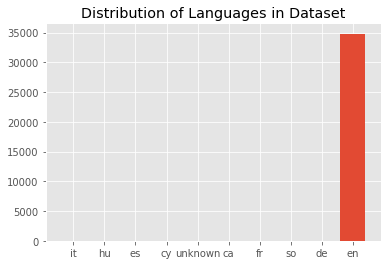

In [ ]:
df['language'] = languages
plt.bar(range(len(languages_dict)), list(languages_dict.values()), align='center')
plt.xticks(range(len(languages_dict)), list(languages_dict.keys()))
plt.title("Distribution of Languages in Dataset")
plt.show()


We will be dropping any language that is not English. Attempting to translate foreign texts gave the following problems:

1. API calls were limited

2. Translating the language may not carry over the true semantic meaning of the text


In [ ]:
df = df[df['language'] == 'en'] 
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34799 entries, 0 to 8019999
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   paper_id             34799 non-null  object
 1   abstract             34799 non-null  object
 2   body_text            34799 non-null  object
 3   authors              34799 non-null  object
 4   title                34799 non-null  object
 5   journal              34799 non-null  object
 6   abstract_summary     34799 non-null  object
 7   abstract_word_count  34799 non-null  int64 
 8   body_word_count      34799 non-null  int64 
 9   body_unique_words    34799 non-null  int64 
 10  language             34799 non-null  object
dtypes: int64(3), object(8)
memory usage: 3.2+ MB


In [ ]:
#Download the spacy bio parser
from IPython.utils import io
with io.capture_output() as captured:
  !pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_core_sci_lg-0.4.0.tar.gz
#----------------------------
import spacy.cli
spacy.cli.download("en_core_web_lg")
import en_core_web_lg
nlp = en_core_web_lg.load()
#----------------------------
#NLP 
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_sci_lg  # model downloaded in previous step

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


### Stopwords

Part of the preprocessing will be finding and removing stopwords (common words that will act as noise in the clustering step).

In [ ]:
import string
#punctuations
punctuations = string.punctuation
#stopwords
stopwords = list(STOP_WORDS)
print("----------------------------------")
print("stopwords  :" )
print(stopwords)
print("----------------------------------")
print("punctuations  : ")
print(punctuations)

----------------------------------
stopwords  :
['myself', 'because', 'while', 'hence', 'she', 'toward', 'ten', 'there', 'eight', 'bottom', 'beside', 'itself', 'had', 'will', 'several', 'us', 'been', 'your', 'whether', 'should', 'part', 'somewhere', 'through', 'moreover', 'one', 'former', 'side', 'everywhere', 'thence', 'seems', 'none', 'those', 'after', '‘s', 'take', 'get', 'no', 'otherwise', 'so', 'or', 'however', 'below', 'less', '‘d', 'our', 'meanwhile', 'something', 'nevertheless', "'ve", '‘ve', 'seeming', 'whom', 'are', 'top', 'just', 'either', 'do', 'by', 'same', 'was', '’m', 'before', 'latter', '‘m', 'sixty', 'others', 'up', 'towards', 'go', 'the', 'off', 'due', 'put', 'anyhow', 'quite', 'also', 'may', 'him', 'n’t', 'them', 'used', 'down', 'few', 'often', 'now', 'rather', 'please', 'when', 'which', "'m", "'s", 'own', 'her', 'regarding', 'further', '’d', 'neither', 'nowhere', 'always', 'seemed', 'become', "n't", 'about', 'as', 'thus', 'since', 'back', '’ve', 'whenever', "'re", '

Now the above stopwords are used in everyday english text. Research papers will often frequently use words that don't actually contribute to the meaning and are not considered everyday stopwords.


In [ ]:
custom_stop_words = [
    'doi', 'preprint', 'copyright', 'peer', 'reviewed', 'org', 'https', 'et', 'al', 'author', 'figure', 
    'rights', 'reserved', 'permission', 'used', 'using', 'biorxiv', 'medrxiv', 'license', 'fig', 'fig.', 
    'al.', 'Elsevier', 'PMC', 'CZI', 'www' , 'the' , 'THE' ,"19" ,"-"]

for w in custom_stop_words:
    if w not in stopwords:
        stopwords.append(w)

### Next lets create a function that will process the text data for us. 
For this purpose we will be using the spacy library. This function will convert text to lower case, remove punctuation, and find and remove stopwords. For the parser, we will use en_core_sci_lg. This is a model for processing biomedical, scientific or clinical text.

### Stop words , Ponctuation and Lemmatizing

In [ ]:
import spacy
import re
nlp = en_core_web_lg.load()
def spacy_process(texte):

    #URLs
    string = re.sub(r"https?://\S+|www.\S+",'',texte)
    #html 
    string = re.sub(r'<.*?>','',string)
    #Numbers
    string = re.sub(r'[0-9]+','',string) 

    mytokens = nlp(string)
    mytokens2 = [word.lemma_.lower().strip() for word in mytokens if word.pos_ != "PUNCT" and word.text.lower() not in stopwords and word.text.lower() not in punctuations]
    mytokens2 = " ".join([i for i in mytokens2])
    return mytokens2
df["processed_text"] = df["body_text"].apply(spacy_process)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
#df["processed_text"].to_csv("text_cleaned.csv")

In [ ]:
#df.to_csv("text_cleaned_all_df.csv")

### Exemple for lemmatizing with Lemma

it doesn't detect the conjugaison of the verbs so we need to use an other lemmmatizer

In [ ]:
test1 = spacy_process("vaccinations")
test2 = spacy_process("vaccination")
test3 = spacy_process("vaccinating")
test4 = spacy_process("vaccinated")
print("vaccinations  :" , test1)
print("vaccination  :" ,test2)
print("vaccinating  :" ,test3)
print("vaccinated  :" ,test4)

vaccinations  : vaccination
vaccination  : vaccination
vaccinating  : vaccinate
vaccinated  : vaccinate


In [ ]:
# processed_text = df["processed_text"]
# body_text = df["body_text"]

# for i in range(0,10):
#     print("body_text[i]")
#     print(body_text[i])
#     print("")
#     print("processed_text[i]")
#     print(processed_text[i])
#     print("")
#     print("----------------------------------------------------------")



### Let's take a look at word count in the papers

In [ ]:
import seaborn as sns

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


count    34799.000000
mean       221.467916
std         81.082509
min          0.000000
25%        169.000000
50%        221.000000
75%        263.000000
max       2078.000000
Name: body_word_count, dtype: float64

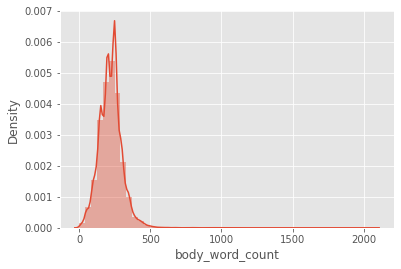

In [ ]:
sns.distplot(df['body_word_count'])
df['body_word_count'].describe()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


count    34799.000000
mean       141.038248
std         42.175838
min          0.000000
25%        114.000000
50%        142.000000
75%        166.000000
max        721.000000
Name: body_unique_words, dtype: float64

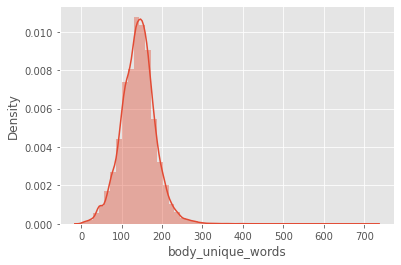

In [ ]:
sns.distplot(df['body_unique_words'])
df['body_unique_words'].describe()

# Vectorisation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

df = pd.read_csv("/content/text_cleaned.csv")
df.drop(columns="Unnamed: 0",inplace=True)
df.dropna(inplace=True)

FileNotFoundError: ignored

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
def vectorize(text):
    
    global vectorizer 
    X = vectorizer.fit_transform(text)
    return X
#-----------------------------------------------------------
text = df['processed_text'].values
vectorizer = TfidfVectorizer(max_features= 2 ** 12)
X = vectorize(text)
X.shape

(34798, 4096)

In [ ]:
# on doit vérifier si le vectorizer prend 2**12 premiers mots ou bien par nombre d'occurences 
all_terms_tfidf = vectorizer.get_feature_names()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


# Coclust

In [ ]:
# ** Compute the final coClust modularity on a range of number of clusters **

# -- range of number of clusters
# ---- get min
min_cluster_nbr = 2
max_cluster_nbr = 9
range_n_clusters = range(min_cluster_nbr, (max_cluster_nbr+1))

# -- Number of random initialization per cluster number
n_rand_init = 1

# --  max modularity for all models
model, all_max_modularities = best_modularity_partition(X,range_n_clusters, n_rand_init)

Computing coclust modularity for a range of cluster numbers =
 2 ...
 3 ...
 4 ...
 5 ...
 6 ...
 7 ...
 8 ...
 9 ...
 All done !


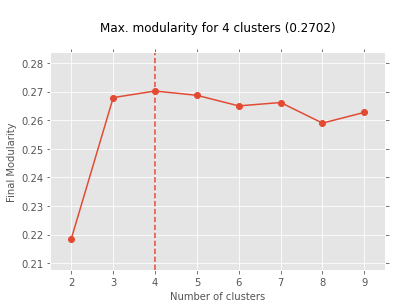

In [ ]:
# ** Plot all final modularities **
plot_max_modularities(all_max_modularities, range_n_clusters)

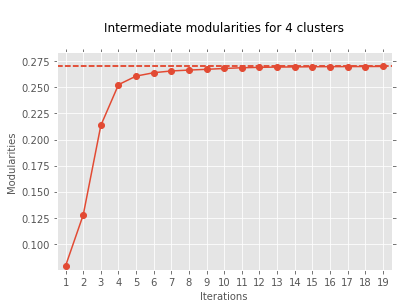

In [ ]:
# ** Plot intermediate modularities for the best CoClust final modularity **
plot_intermediate_modularities(model)

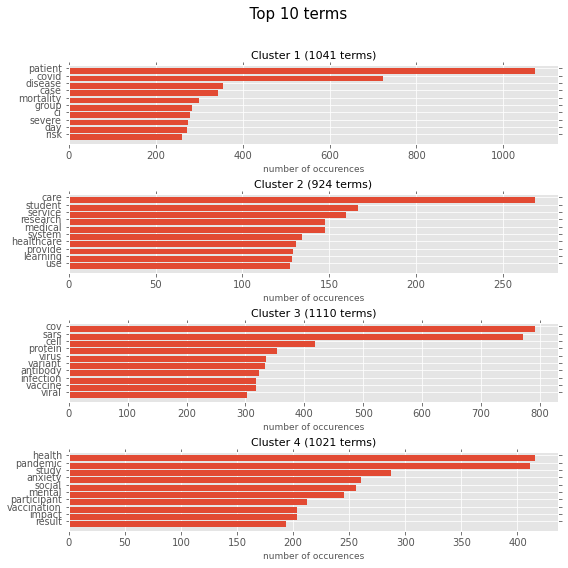

taille de chaque cluster :


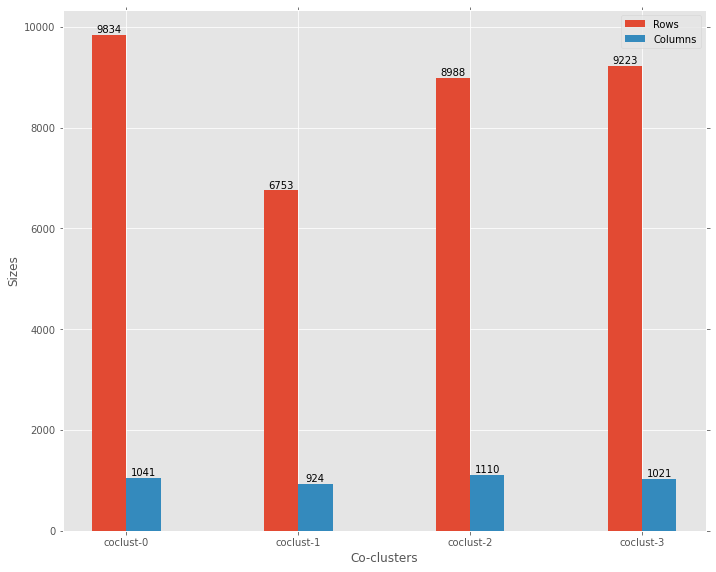

In [ ]:
# ** Plot top terms for each cluster and the cluster sizes **
n_terms = 10

# --> top terms
plot_cluster_top_terms(X, all_terms_tfidf, n_terms, model)
# --> cluster sizes
print("taille de chaque cluster :")
plot_cluster_sizes(model)

In [ ]:
# ** Plot the term graph for a given cluster of terms **
#graph = get_term_graph(X,model, all_terms_tfidf, 4, 10, 3)

In [ ]:
# %%javascript
# require.config({
#   paths: {
#       d3: '//cdnjs.cloudflare.com/ajax/libs/d3/3.4.8/d3.min'
#   }
# });


<IPython.core.display.Javascript object>

In [ ]:
# from IPython.display import Javascript
# #runs arbitrary javascript, client-side
# Javascript("""
#            window.graph={};
#            """.format(graph))

<IPython.core.display.Javascript object>

In [ ]:
# %%javascript
# require(['d3'], function(d3){
#   //a weird idempotency thing
#   $("#chart1").remove();
#   //create canvas
#   element.append("<div id='chart1'></div>");
#   $("#chart1").width("1160px");
#   $("#chart1").height("800px");        
#   var margin = {top: 20, right: 20, bottom: 30, left: 40};
#   var width = 1280 - margin.left - margin.right;
#   var height = 800 - margin.top - margin.bottom;
#   var svg = d3.select("#chart1").append("svg")
#     .style("position", "relative")
#     .style("max-width", "960px")
#     .attr("width", width + "px")
#     .attr("height", (height + 50) + "px")
#     .call(d3.behavior.zoom().on("zoom", redraw))
#     .append("g")
#     .attr("transform", "translate(" + margin.left + "," + margin.top + ")");
    
    
#   function redraw() {
#       svg.attr("transform",
#                "translate(" + d3.event.translate + ")"
#                + " scale(" + d3.event.scale + ")");
#   }   

#   var color = d3.scale.category20();

#   var force = d3.layout.force()
#     .charge(-500)
#     //.linkDistance(5)
#     .linkDistance(function(d) { return (1 - d.value); })
#     .size([width, height]);

#   var graph = window.graph;
    
#   force
#       .nodes(graph.nodes)
#       .links(graph.links)
#       .start();

#   var link = svg.selectAll(".link")
#       .data(graph.links)
#       .enter().append("line")
#       .attr("class", "link")
#       .style("stroke", "#999;")
#       .style("stroke-opacity", .6)
#       .style("stroke-width", function(d) { return Math.sqrt(d.value); })
  
#       .style("stroke", "blue");

#   var node = svg.selectAll(".node")
#       .data(graph.nodes)
#       .enter().append("g")
#       .attr("class", "node")
#       .call(force.drag);
    
#   node.append("circle")
#       .attr("class", "node_circle")
#       .attr("r", 8)
#       .style("fill", function(d) { return color(d.group); });

#   node.append("text")
#       .attr("class", "node_text")
#       .attr("dx", 12)
#       .attr("dy", ".35em")
#       .text(function(d) { return d.name });

#   node.append("title")
#       .text(function(d) { return d.name; });

#   var node_text = svg.selectAll(".node_text");
#   var node_circle = svg.selectAll(".node_circle");
    
#   force.on("tick", function() {
#     link.attr("x1", function(d) { return d.source.x; })
#         .attr("y1", function(d) { return d.source.y; })
#         .attr("x2", function(d) { return d.target.x; })
#         .attr("y2", function(d) { return d.target.y; });

#     node_circle.attr("cx", function(d) { return d.x; })
#         .attr("cy", function(d) { return d.y; });
      
#     node_text.attr("x", function(d) { return d.x; })
#         .attr("y", function(d) { return d.y; });
#   });
# });

### Compute spectral co-clustering with the CoclustSpecMod approach 

In [ ]:
# ** Compute spectral co-clustering with the CoclustSpecMod approach **

n_clusters = model.n_clusters
# Perform co-clustering
coclust_specMod_model = CoclustSpecMod(n_clusters=n_clusters, random_state=0)
coclust_specMod_model.fit(X)

proble RAM plante

In [ ]:
# ** Plot top terms for each cluster and the cluster sizes **

n_terms = 10

# --> top terms
plot_cluster_top_terms(X, all_terms_tfidf, n_terms, coclust_specMod_model)
# --> cluster sizes
plot_cluster_sizes(coclust_specMod_model)

### Compute co-clustering with the CoclustInfo approach

In [ ]:
# ** Compute co-clustering with the CoclustInfo approach **

n_clusters = model.n_clusters
n_rand_init = input_with_default_int('Number of random initialization', 1)
# Perform co-clustering
coclust_info_model = CoclustInfo(n_row_clusters = n_clusters, n_col_clusters = n_clusters,
                                 n_init = n_rand_init, random_state = 0)
coclust_info_model.fit(X)

### Comparaison

In [ ]:
# ** Compare clustering quality measure for coClustMod, coClustSpecMod and info **

true_row_labels = all_terms_tfidf
n_clusters = model.n_clusters

def print_NMI_and_ARI(true_row_labels, predicted_row_labels):
    nmi_ = nmi(true_row_labels, predicted_row_labels)
    ari_ = ari(true_row_labels, predicted_row_labels)
    print("NMI: {}\nARI: {}".format(nmi_, ari_))

## Evaluate the results for (Best) Modularity co-clustering
print(10*'=')
print("(Best) Modularity co-clustering")
print(5*'-')
#print("CRITERION: %s" % best_coclustMod_model.criterion)
predicted_row_labels = model.row_labels_
print_NMI_and_ARI(true_row_labels, predicted_row_labels)
#print_accuracy = accuracy(true_row_labels, predicted_row_labels)
print("ACCURACY: %s" % print_accuracy)
            
## Evaluate the results for Spectral Modularity co-clustering
print(10*'=')
print("Spectral Modularity co-clustering")
print(5*'-')
#print("CRITERION: %s" % coclust_specMod_model.criterion)
predicted_row_labels = coclust_specMod_model.row_labels_
#print_NMI_and_ARI(true_row_labels, predicted_row_labels)
#print_accuracy = accuracy(true_row_labels, predicted_row_labels)
print("ACCURACY: %s" % print_accuracy)
      
## Evaluate the results for Info co-clustering
print(10*'=')
print("Info co-clustering")
print(5*'-')
print("CRITERION: %s" % coclust_info_model.criterion)
predicted_row_labels = coclust_info_model.row_labels_
print_NMI_and_ARI(true_row_labels, predicted_row_labels)
#print_accuracy = accuracy(true_row_labels, predicted_row_labels)
print("ACCURACY: %s" % print_accuracy)

RAM plante bcp !!!